# imports

In [12]:
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import glob
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
import src.mex_helper as mex
import folium
from src.utils.map_vis import time_slider_choropleth, geojson_per_row

In [14]:
from scipy import stats


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import src.utils.gis as gis
from src.features import *

# grid average

In [6]:
def grid_avgerage(tw_avg, t2g):
    # there are grids without any call throughout the observation period
    g_avg = t2g.merge(tw_avg, left_on='gtid', right_index=True, how='left')

    for h in range(24):
        h = str(h)
        g_avg[h] = g_avg[h] * g_avg['weight']

    g_avg = g_avg.drop(['gtid', 'weight'],
                       axis=1).groupby('grid').sum()  # fillna=0 by default

    return g_avg

In [7]:
aver = mex.stat_tw_dow_aver_hr_uniq_user('out+in')
tw_avg_wd = pd.DataFrame(aver['wd']).T
tw_avg_wk = pd.DataFrame(aver['wk']).T

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle


In [20]:
mex_urban = mex.urban_areas_16()

In [8]:
gsides = [500, 1000, 2000]
n_regions = 16

In [9]:
mex_t2g_urban = {}
g_avg_wd_urban={}
g_avg_wk_urban={}
dv_r_urban = {}
for gside in gsides:
    t2g = mex.tower2grid('urban_areas_16', gside)
    print(
    'number of towers in cities has no call at all during weekday and weekend',
    len(set(t2g.gtid) - set(tw_avg_wd.index)),
    len(set(t2g.gtid) - set(tw_avg_wk.index)))
    avg_wd = grid_avgerage(tw_avg_wd, t2g)
    avg_wk = grid_avgerage(tw_avg_wk, t2g)
    dv_wd = urban_dilatation_index(avg_wd, 'urban_areas_16', 'urban', gside)    
    
    mex_t2g_urban[gside] = t2g
    g_avg_wd_urban[gside] = avg_wd
    g_avg_wk_urban[gside] = avg_wk
    dv_r_urban[gside] = dv_wd

reading existing t2g file: data/mex_tower/mex_t2g_urban_areas_16_500m.csv
number of towers in cities has no call at all during weekday and weekend 223 223
reading existing grids
reading existing t2g file: data/mex_tower/mex_t2g_urban_areas_16_1000m.csv
number of towers in cities has no call at all during weekday and weekend 223 223
reading existing grids
reading existing t2g file: data/mex_tower/mex_t2g_urban_areas_16_2000m.csv
number of towers in cities has no call at all during weekday and weekend 223 223
reading existing grids


In [10]:
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

# dilation coefficient is similar

In [11]:
tmp = dv_r_urban[1000].drop('dilatation coefficient', axis=1)
offline.iplot({
    'data':[{'x': list(range(24)), 'y': tmp.loc[r].tolist(), 'name': r} for r in tmp.index]
})

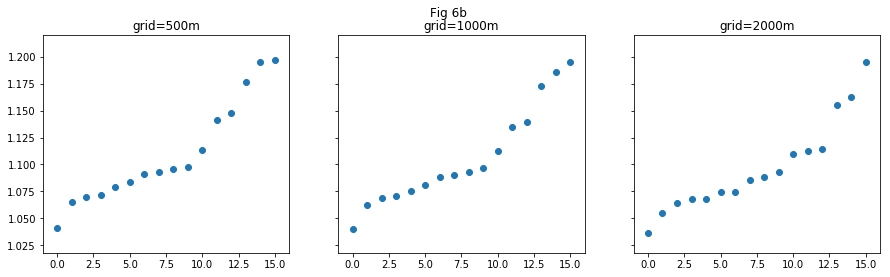

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4))
fig.suptitle('Fig 6b')
dc_order = []
for i, gside in enumerate(gsides):
    dv_wd = dv_r_urban[gside]
    dv_wd_sort = dv_wd.sort_values('dilatation coefficient')
    dv_wd_sort[f'{gside}m'] = range(n_regions)
    axes[i].scatter(
        range(n_regions),
        dv_wd_sort['dilatation coefficient'].values)
    dc_order.append(dv_wd_sort[f'{gside}m'])
    axes[i].set_title(f'grid={gside}m')

In [16]:
pd.concat(dc_order, axis=1, sort=False)

,500m,1000m,2000m
"Tijuana, Baja California",0,0,0
"Nuevo Laredo, Tamaulipas",1,1,1
"Cancún, Quintana Roo",2,2,2
"Monterrey, Nuevo León",3,3,4
"Acapulco de Juárez, Guerrero",4,4,3
"Cuernavaca, Morelos",5,5,5
"Guadalajara, Jalisco",6,7,8
"Toluca de Lerdo, México",7,6,6
"Villahermosa, Tabasco",8,8,7
"Juárez, Chihuahua",9,9,9


# hotspot analysis

In [17]:
n_hotspot_urban={}
hotspot_stats_urban={}
permanent_regions_urban = {}
for gside in gsides:
    for hotspot_type in ['loubar', 'average']:
        print(gside, hotspot_type)
        n_hotspot_hourly, h_stats, permanent_regions, =  hotspot_stats(g_avg_wd_urban[gside],'urban_areas_16','urban',gside, hotspot_type)
        n_hotspot_urban[(gside, hotspot_type)]=n_hotspot_hourly
        hotspot_stats_urban[(gside, hotspot_type)]=h_stats
        permanent_regions_urban[(gside, hotspot_type)]= permanent_regions


500 loubar
reading existing grids
500 average
reading existing grids
1000 loubar
reading existing grids
1000 average
reading existing grids
2000 loubar
reading existing grids
2000 average
reading existing grids


## Fig 8 hourly hotspot

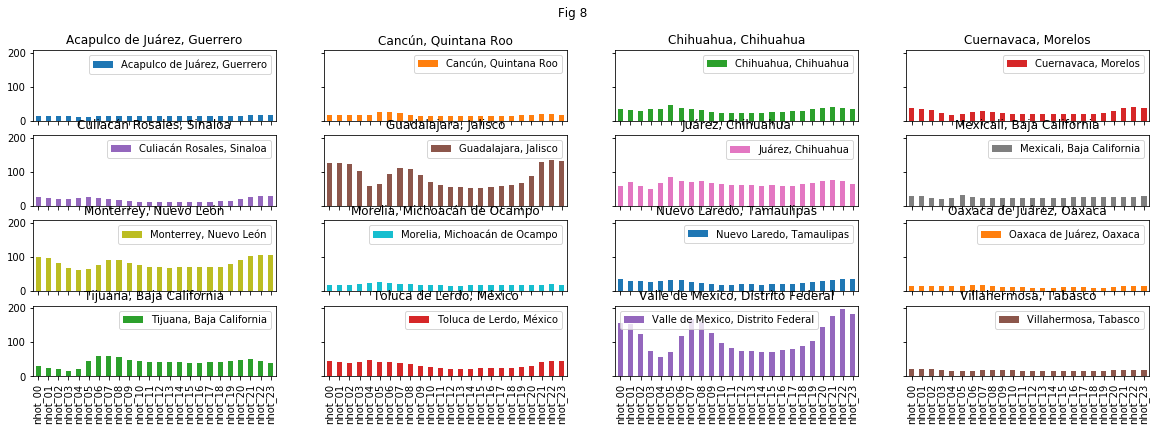

In [18]:
pd.DataFrame(n_hotspot_urban[(1000,'loubar')]).T.plot(kind='bar',figsize=(20,6),subplots=True, layout=(4,4),sharey=True, title='Fig 8')
print()

## Fig 13 H/N

In [19]:
n_grids ={gside:mex.grids('urban_areas_16', gside).groupby('urban').size() for gside in gsides}

reading existing grids
reading existing grids
reading existing grids


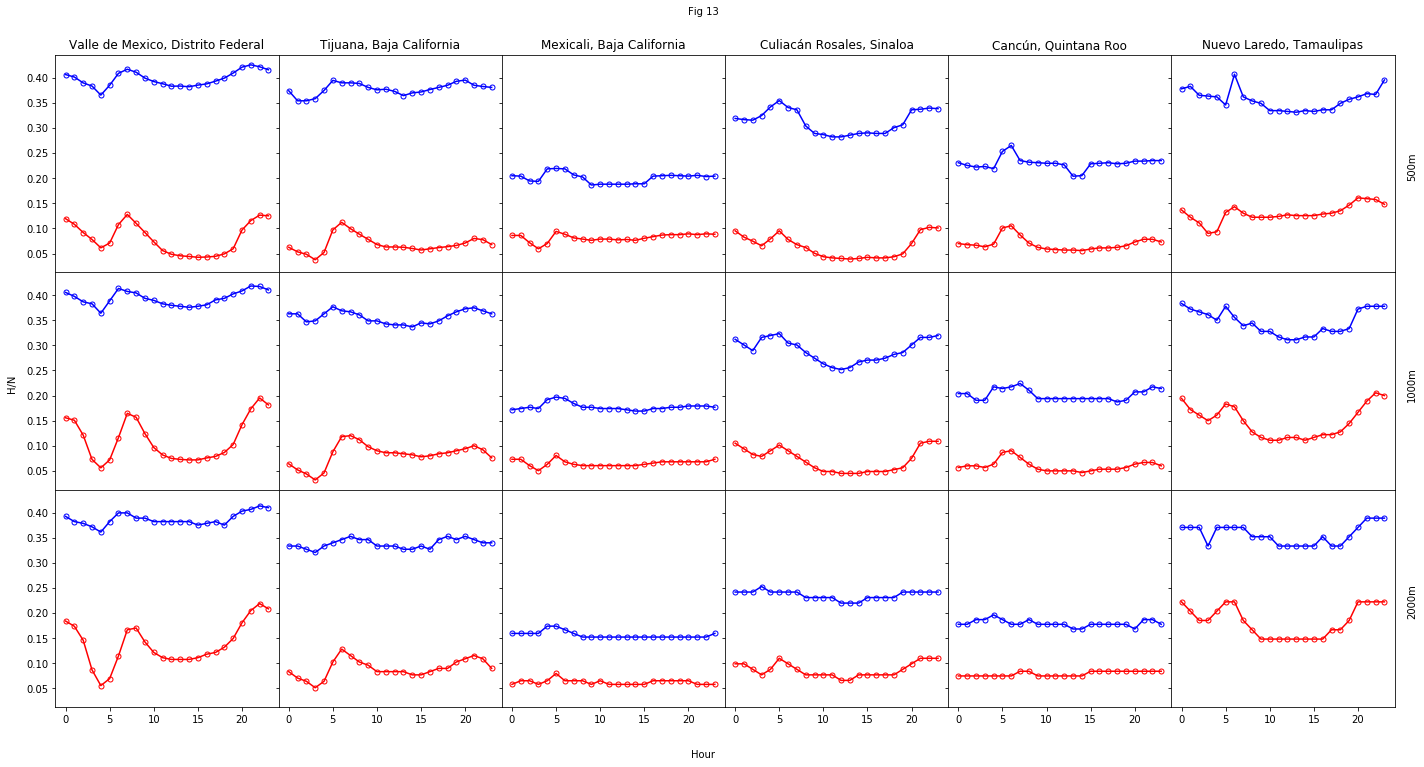

In [23]:
nth_populated_regions = [0,3,6,9,12,15]

n_rows = 3
n_cols = len(nth_populated_regions)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)

fig.text(0.5, .93, 'Fig 13', ha='center', va='center')
fig.text(0.5, 0.07, 'Hour', ha='center', va='center')
fig.text(0.1, 0.5, 'H/N', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace=0)

for i, gside in enumerate(gsides):
    for htype in ['loubar', 'average']:
        color = {'loubar': 'red', 'average': 'blue'}[htype]
        h_by_n = n_hotspot_urban[(gside,htype)].divide(n_grids[gside],axis='rows')
        for j, r in enumerate(mex_urban.index[nth_populated_regions]):
            ax = axes[i,j]

            ax.plot(range(24), h_by_n.loc[r], 'o-', color=color, markerfacecolor='None', markersize=5)
            if i==0:
                ax.set_title(r)
                
for i, gside in enumerate(gsides):
    ax = axes[i,n_cols-1]
    ax.text(ax.get_xlim()[1]+2, ax.get_ylim()[1]*0.5, f'{gside}m', ha='center', va='center', rotation='vertical')

## Fig7 and 14  average_hotspot vs population

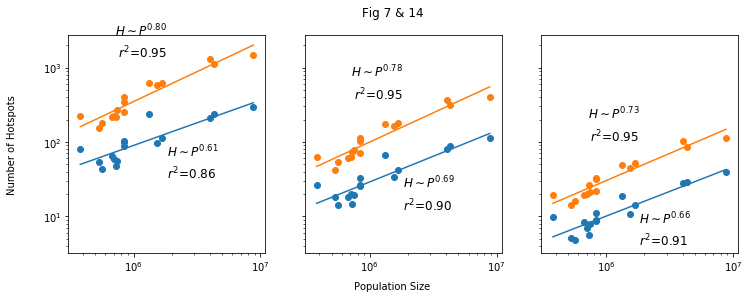

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

fig.suptitle('Fig 7 & 14')
fig.text(0.5, 0.01, 'Population Size', ha='center', va='center')
fig.text(0.06, 0.5, 'Number of Hotspots', ha='center', va='center', rotation='vertical')
# fig.text(1,0.9, r'$H \sim P^{0.6}$')
# fig.text(1, 0.8, r'$r^2 \equal 10$')
for i, gside in enumerate(gsides):
    for hotspot_type in ['loubar', 'average']:
        x = mex_urban.population.sort_index()
        y = n_hotspot_urban[(gside, hotspot_type)].mean(axis=1).sort_index()
        axes[i].scatter(x=x, y=y)
        axes[i].set_xscale("log")
        axes[i].set_yscale("log")
        
        log_x = np.log(x)
        log_y = np.log(y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x,log_y)
        min_max_x = np.array([x.min(), x.max()])
        min_max_y_fit = np.exp(slope * np.log(min_max_x) + intercept)
        log_scale_mean_x = np.exp(np.log(min_max_x).mean())
        axes[i].plot(min_max_x,min_max_y_fit)
        
        if hotspot_type =='average':
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()*2.5, r'$H \sim P^{%.02f}$' % slope, ha='right', fontsize=12)
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()*1.25, r'$r^2 \equal {%.02f}$' % r_value, ha='right', fontsize=12)            
        if hotspot_type =='loubar':
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()/3, r'$H \sim P^{%.02f}$' % slope, ha='left', fontsize=12)
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()/6, r'$r^2 \equal {%.02f}$' % r_value, ha='left', fontsize=12)            

## Fig 9a Compacity Coef. 

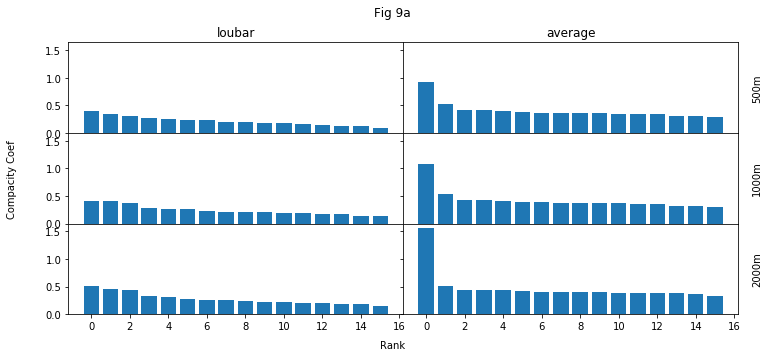

In [29]:
fig, axes = plt.subplots(len(gsides), 2, sharex=True, sharey=True, figsize=(12,5))
cc_order = []
fig.suptitle('Fig 9a')
fig.text(0.5, 0.04, 'Rank', ha='center', va='center')
fig.text(0.06, 0.5, 'Compacity Coef', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace=0)

for i, gside in enumerate(gsides):
    for j, hotspot_type in enumerate(['loubar', 'average']):
        hstats =  pd.DataFrame(hotspot_stats_urban[(gside, hotspot_type)])
        hstats_sort = hstats.compacity_coefficient.sort_values(ascending=False).to_frame()
        hstats_sort[(hotspot_type, gside)] = range(n_regions)
        cc_order.append(hstats_sort[(hotspot_type, gside)])
        
        ax = axes[i,j]
        ax.bar(range(n_regions), hstats_sort.compacity_coefficient)

        if i==0:
            ax.set_title(hotspot_type)
                
for i, gside in enumerate(gsides):
    ax = axes[i,1]
    ax.text(ax.get_xlim()[1]+1, ax.get_ylim()[1]*0.5, f'{gside}m', ha='center', va='center', rotation='vertical')

In [32]:
pd.concat(cc_order, axis=1, sort=False).T.sort_index().T[['loubar','average']]

loubar           average          
                                    500  1000 2000    500  1000 2000
Juárez, Chihuahua                      0    1    2       3    3    4
Tijuana, Baja California               1    0    0       2    2    2
Acapulco de Juárez, Guerrero           2    2    1       1    1    1
Guadalajara, Jalisco                   3    7   12       8    9   11
Cuernavaca, Morelos                    4    3   10       9    5    3
Monterrey, Nuevo León                  5    4   11       4    4    5
Mexicali, Baja California              6    9    9       0    0    0
Chihuahua, Chihuahua                   7    5    4       7    6    8
Nuevo Laredo, Tamaulipas               8    6    5       6    7    6
Cancún, Quintana Roo                   9   10    8      14   14   14
Morelia, Michoacán de Ocampo          10   11    6      11   11    7
Villahermosa, Tabasco                 11    8    7      13   13    9
Oaxaca de Juárez, Oaxaca              12   14   14      15   15   15
Valle de Mexico, Distrito Federal     13   13   13       5    8   13
Culiacán Rosales, Sinaloa             14   12    3      12   12   10
Toluca de Lerdo, México               15   15   15      10   10   12

## Fig 15 Permenant hotspot ranking variation

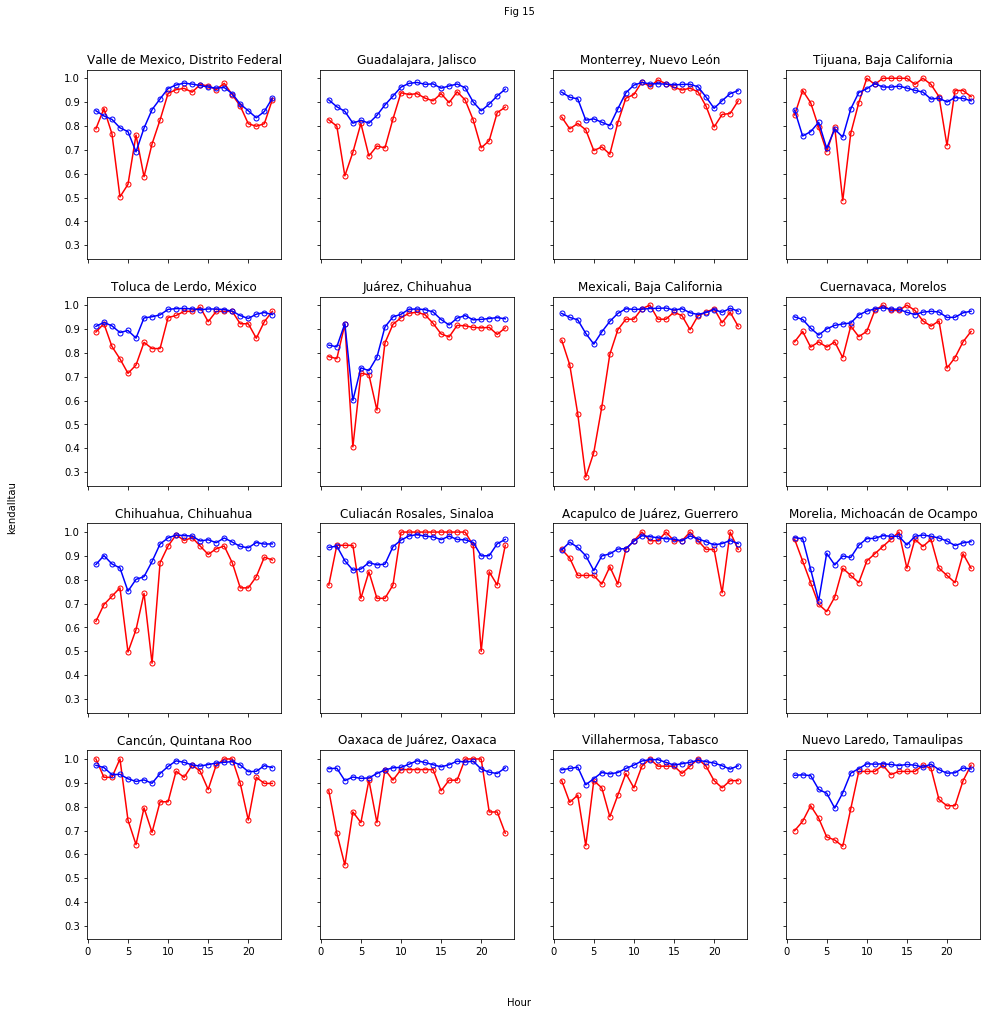

In [33]:
#
n_rows = 4
n_cols = 4
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(16, 16), sharex=True, sharey=True)

fig.text(0.5, 0.93, 'Fig 15', ha='center', va='center')
fig.text(0.5, 0.07, 'Hour', ha='center', va='center')
fig.text(0.06, 0.5, 'kendalltau', ha='center', va='center', rotation='vertical')
for htype in ['loubar', 'average']:
    color = {'loubar': 'red', 'average': 'blue'}[htype]
    regions = permanent_regions_urban[(1000, htype)]
    for i, r in enumerate(mex_urban.index):
        ax = axes[i // 4, i % 4]
        per_spots = regions[r]
        taus = [
            stats.kendalltau(per_spots[t1], per_spots[t2])[0]
            for t1, t2 in zip(per_spots.columns, per_spots.columns[1:])
        ]
        ax.plot(range(1, 24), taus, 'o-', color=color, markerfacecolor='None', markersize=5)
        ax.set_title(r)

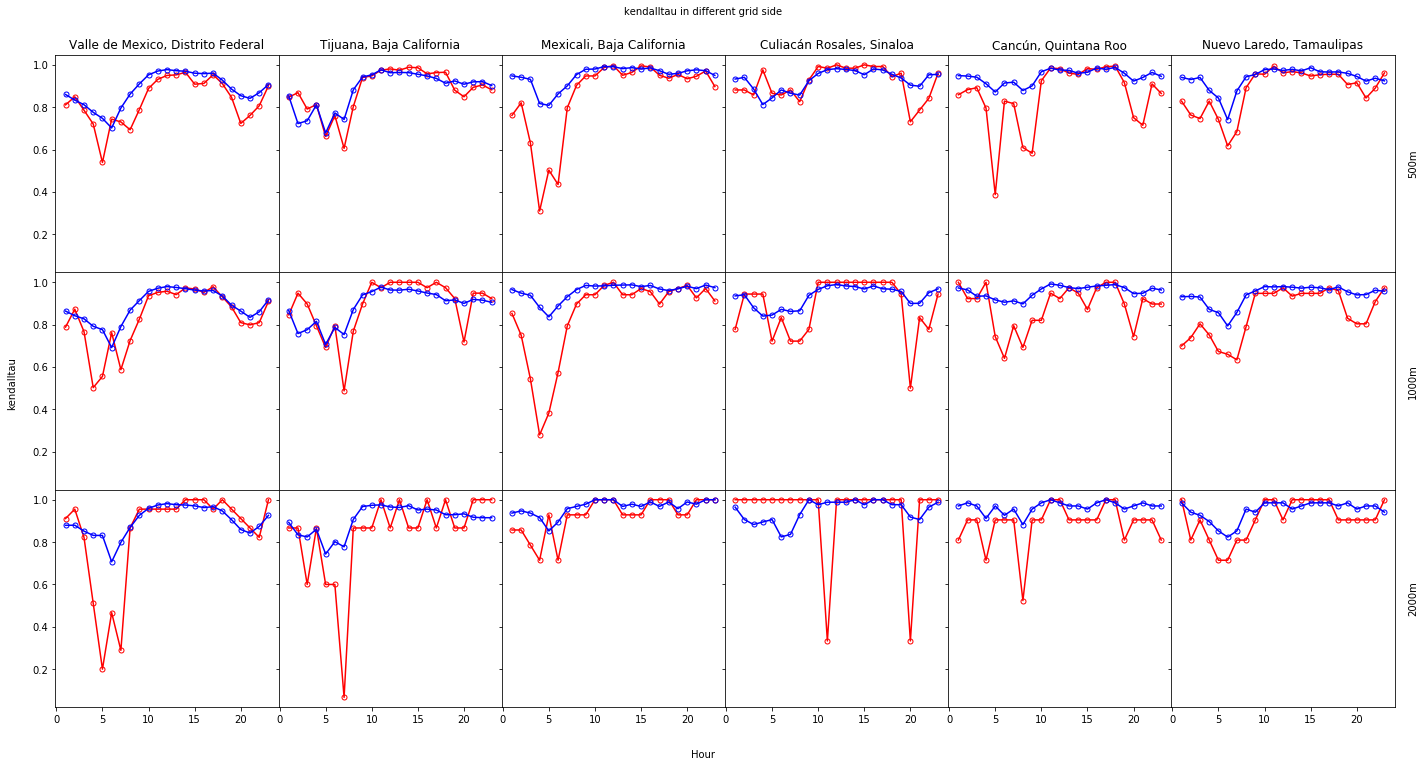

In [34]:
nth_populated_regions = [0,3,6,9,12,15]

n_rows = 3
n_cols = len(nth_populated_regions)
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)

fig.text(0.5, .93, 'kendalltau in different grid side', ha='center', va='center')
fig.text(0.5, 0.07, 'Hour', ha='center', va='center')
fig.text(0.1, 0.5, 'kendalltau', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace=0)
for i, gside in enumerate(gsides):
    for htype in ['loubar', 'average']:
        color = {'loubar': 'red', 'average': 'blue'}[htype]
        regions = permanent_regions_urban[(gside, htype)]
        for j, r in enumerate(mex_urban.index[nth_populated_regions]):
            ax = axes[i,j]
            per_spots = regions[r]
            taus = [
                stats.kendalltau(per_spots[t1], per_spots[t2])[0]
                for t1, t2 in zip(per_spots.columns, per_spots.columns[1:])
            ]
            ax.plot(range(1, 24), taus, 'o-', color=color, markerfacecolor='None', markersize=5)
            if i==0:
                ax.set_title(r)

                     
for i, gside in enumerate(gsides):
    ax = axes[i,n_cols-1]
    ax.text(ax.get_xlim()[1]+2, sum(ax.get_ylim())*0.5, f'{gside}m', ha='center', va='center', rotation='vertical')

## Fig 10

In [19]:
import seaborn as sns

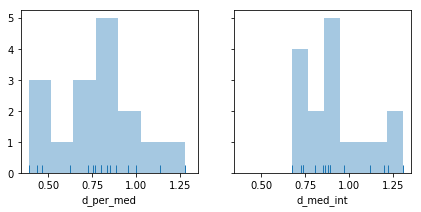

In [20]:
f, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
sns.distplot(hotspot_stats_urban.d_per_med, kde=False, rug=True,bins=7, ax=axes[0])
sns.distplot(hotspot_stats_urban.d_med_int, kde=False, rug=True,bins=7, ax=axes[1])